# DS-502: Análisis Exploratorio de Datos (EDA)

**Proyecto**: RetainAI - Predicción de Churn

**Objetivo**: Realizar análisis exploratorio completo del dataset de clientes para identificar patrones y relaciones con la cancelación.

## Contenido
1. Carga y validación
2. Análisis univariado
3. Análisis bivariado
4. Correlaciones
5. Análisis por segmentos
6. Análisis geográfico
7. Insights y recomendaciones

## 1. Setup - Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print(f"Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Fecha de análisis: 2026-01-13 18:30:25


## 2. Carga y Validación del Dataset

In [2]:
# Cargar dataset
df = pd.read_csv('../data/raw/dataset_base_10k_es.csv')

print(f"Dimensiones: {df.shape[0]:,} registros × {df.shape[1]} columnas")
print(f"Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dimensiones: 9,701 registros × 42 columnas
Tamaño en memoria: 13.63 MB


In [3]:
# Tasa de churn
churn_rate = (df['Cancelacion']=='Si').sum() / len(df) * 100
print(f"Tasa de churn: {churn_rate:.2f}%\n")
print(df['Cancelacion'].value_counts())

Tasa de churn: 26.35%

Cancelacion
No    7145
Si    2556
Name: count, dtype: int64


In [4]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9701 entries, 0 to 9700
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ClienteID              9701 non-null   object 
 1   FechaRegistro          9701 non-null   object 
 2   Genero                 9701 non-null   object 
 3   EsMayor                9701 non-null   int64  
 4   TienePareja            9701 non-null   object 
 5   TieneDependientes      9701 non-null   object 
 6   Ciudad                 9701 non-null   object 
 7   Estado                 9701 non-null   object 
 8   Borough                9701 non-null   object 
 9   CodigoPostal           9701 non-null   int64  
 10  Latitud                9701 non-null   float64
 11  Longitud               9701 non-null   float64
 12  IngresoMediano         9701 non-null   int64  
 13  DensidadPoblacional    9701 non-null   int64  
 14  ServicioTelefono       9701 non-null   object 
 15  Line

In [5]:
# Separar variables por tipo
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

id_cols = ['ClienteID', 'FechaRegistro']
target_col = 'Cancelacion'

numeric_features = [col for col in numeric_cols if col not in id_cols and col != target_col]
categorical_features = [col for col in categorical_cols if col not in id_cols and col != target_col]

print(f"Variables numéricas: {len(numeric_features)}")
print(f"Variables categóricas: {len(categorical_features)}")

Variables numéricas: 18
Variables categóricas: 21


## 3. Análisis Univariado - Variables Numéricas

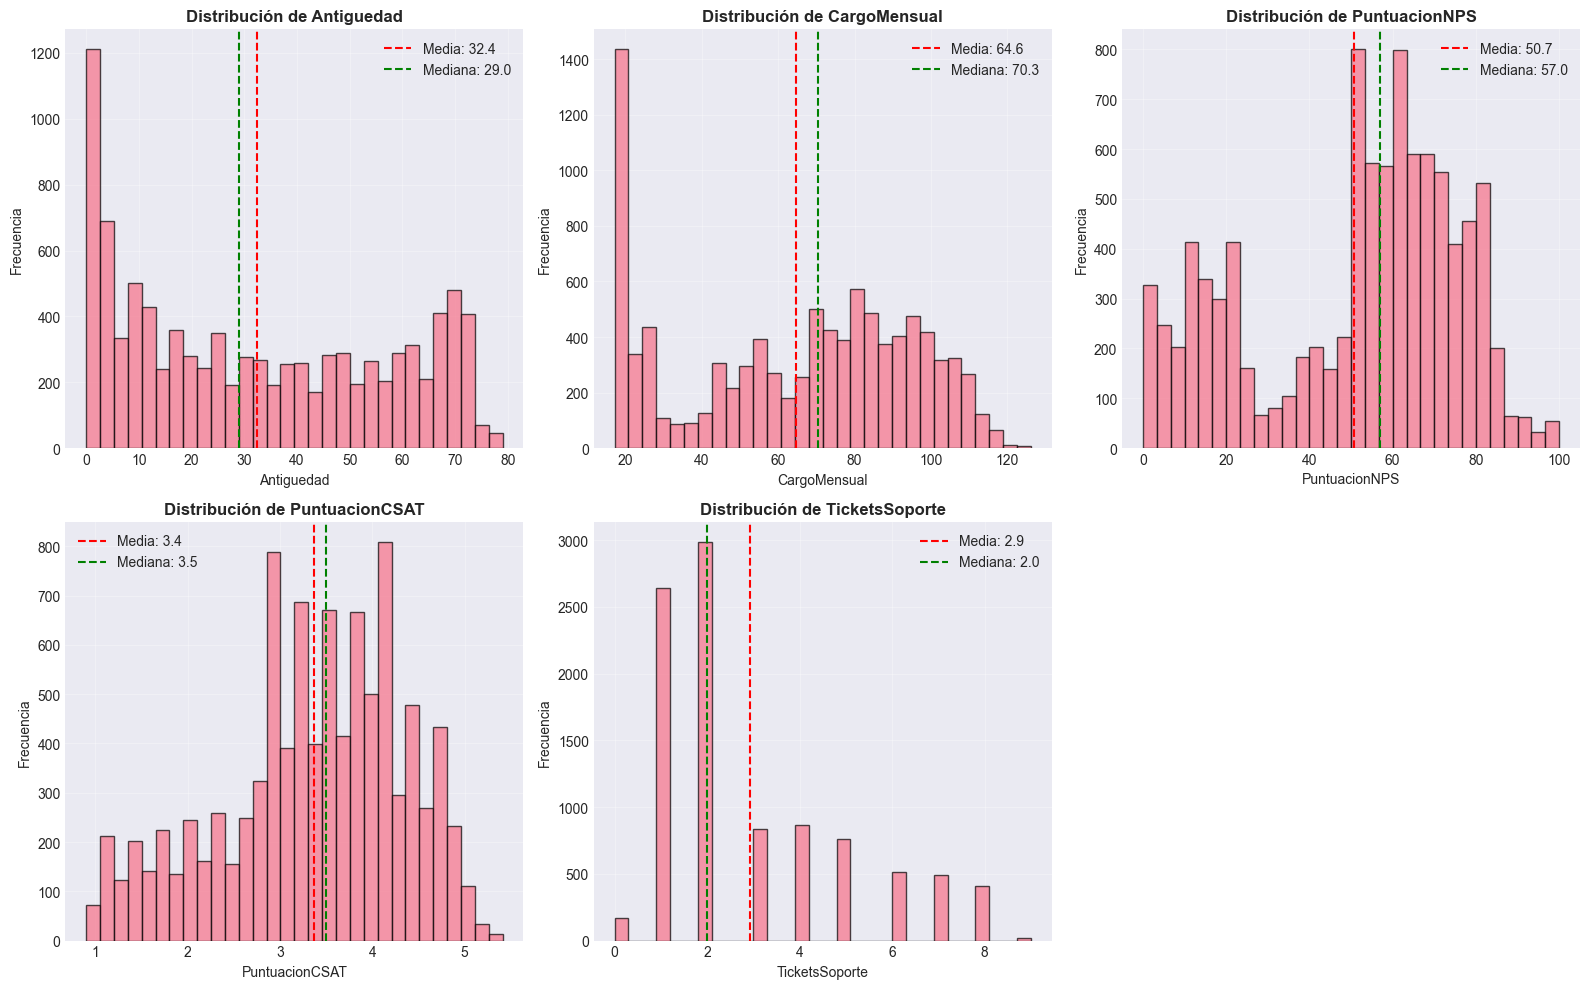

In [6]:
# Distribución de variables numéricas clave
key_numeric = ['Antiguedad', 'CargoMensual', 'PuntuacionNPS', 'PuntuacionCSAT', 'TicketsSoporte']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(key_numeric):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribución de {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(alpha=0.3)
    
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.1f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.1f}')
    axes[i].legend()

fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig('../reports/figures/02_distribucion_numericas.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Análisis Univariado - Variables Categóricas

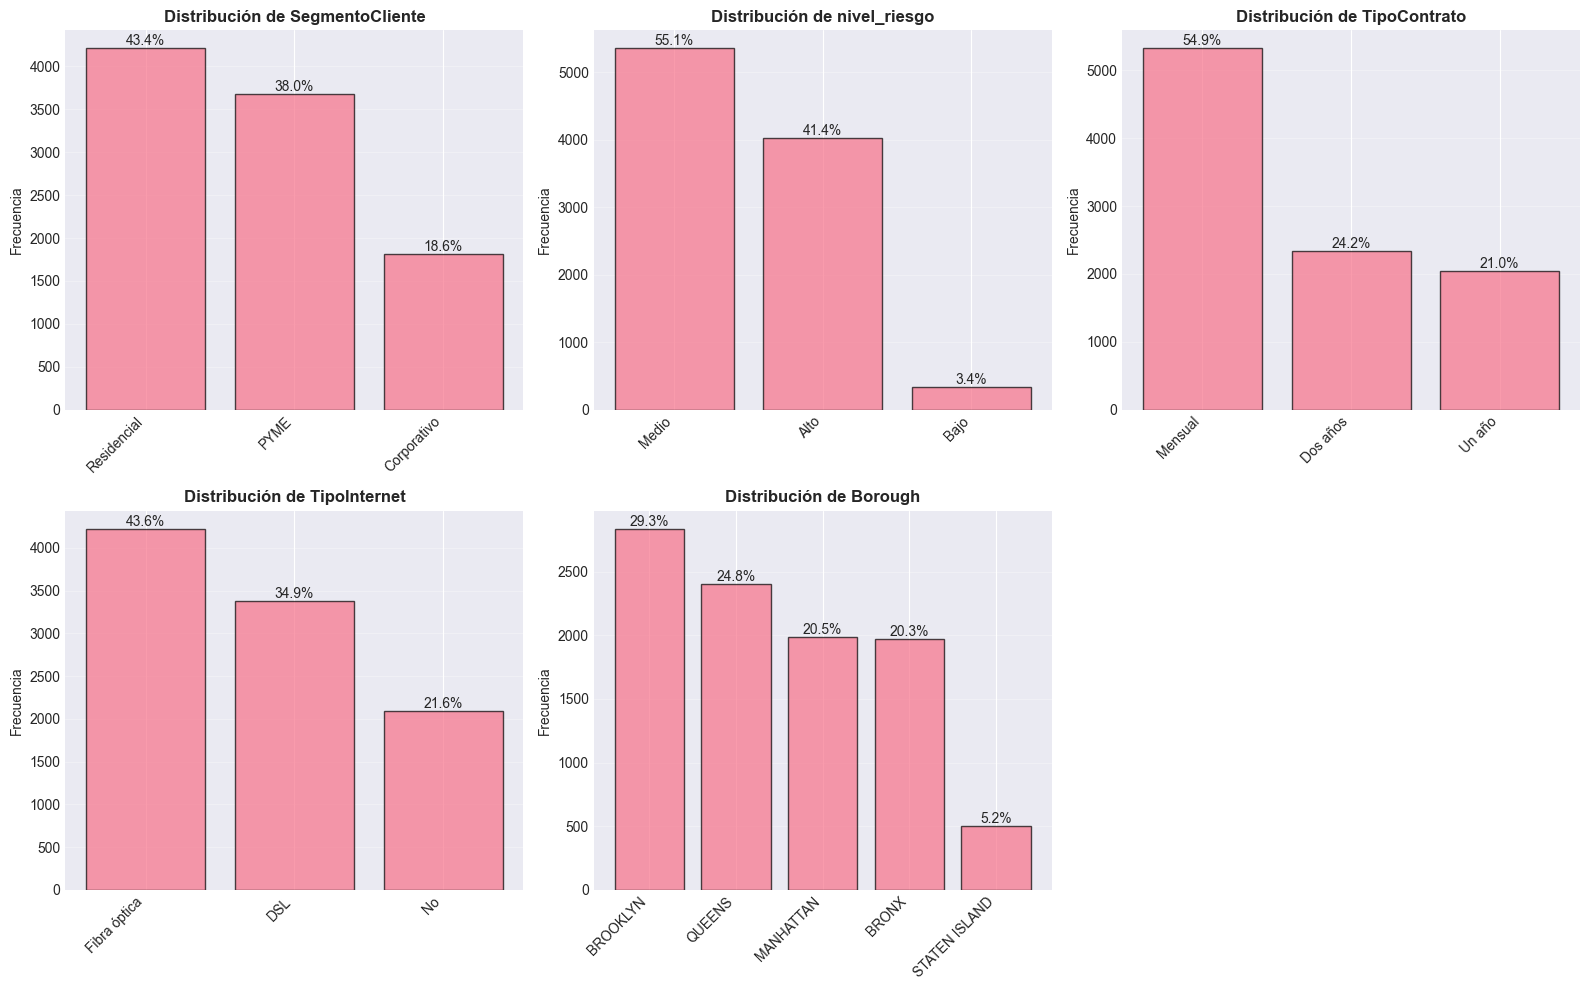

In [7]:
# Distribución de variables categóricas clave
key_categorical = ['SegmentoCliente', 'nivel_riesgo', 'TipoContrato', 'TipoInternet', 'Borough']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(key_categorical):
    value_counts = df[col].value_counts()
    axes[i].bar(range(len(value_counts)), value_counts.values, edgecolor='black', alpha=0.7)
    axes[i].set_xticks(range(len(value_counts)))
    axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[i].set_title(f'Distribución de {col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(alpha=0.3, axis='y')
    
    for j, v in enumerate(value_counts.values):
        pct = v / len(df) * 100
        axes[i].text(j, v, f'{pct:.1f}%', ha='center', va='bottom')

fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig('../reports/figures/02_distribucion_categoricas.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Análisis del Target (Cancelación)

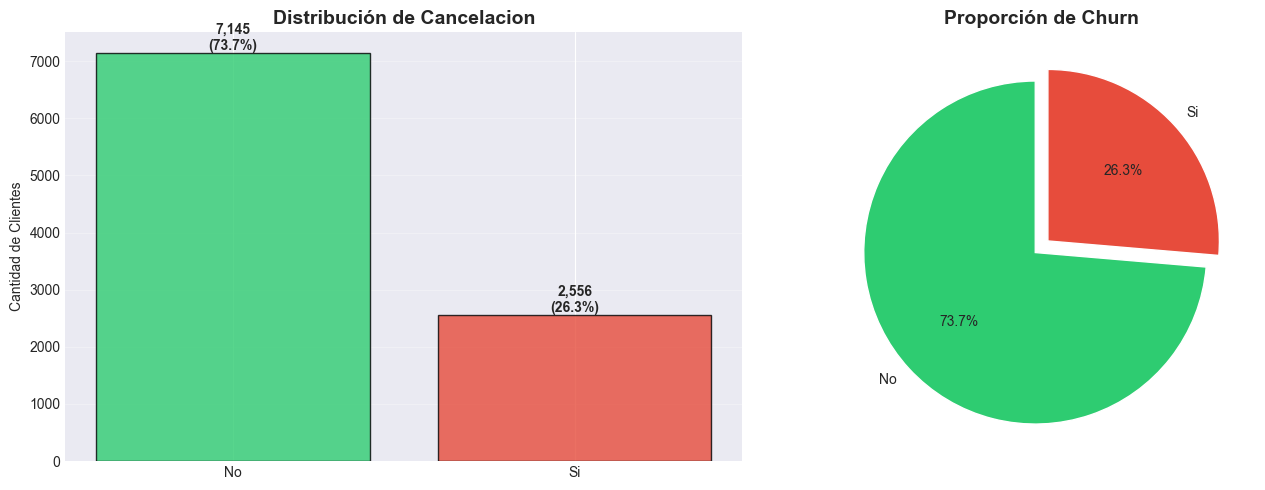

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

target_counts = df['Cancelacion'].value_counts()
colors = ['#2ecc71', '#e74c3c']

# Gráfico de barras
axes[0].bar(target_counts.index, target_counts.values, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_title('Distribución de Cancelacion', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cantidad de Clientes')
axes[0].grid(alpha=0.3, axis='y')

for i, v in enumerate(target_counts.values):
    pct = v / len(df) * 100
    axes[0].text(i, v, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Gráfico de torta
axes[1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90, explode=(0.05, 0.05))
axes[1].set_title('Proporción de Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/02_distribucion_target.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Análisis Bivariado - Features vs Churn

In [9]:
# Separar churners y no churners
churners = df[df['Cancelacion'] == 'Si']
no_churners = df[df['Cancelacion'] == 'No']

# Comparación de promedios
comparison_vars = ['Antiguedad', 'CargoMensual', 'PuntuacionNPS', 'PuntuacionCSAT',
                   'TicketsSoporte', 'IngresoMediano', 'score_riesgo']

print("Comparación de Promedios:\n")
for var in comparison_vars:
    churn_val = churners[var].mean()
    no_churn_val = no_churners[var].mean()
    diff = churn_val - no_churn_val
    print(f"{var:<25}: Churners={churn_val:>8.2f} | No-Churners={no_churn_val:>8.2f} | Diff={diff:>8.2f}")

Comparación de Promedios:

Antiguedad               : Churners=   17.76 | No-Churners=   37.63 | Diff=  -19.88
CargoMensual             : Churners=   74.24 | No-Churners=   61.19 | Diff=   13.05
PuntuacionNPS            : Churners=   14.09 | No-Churners=   63.78 | Diff=  -49.69
PuntuacionCSAT           : Churners=    2.08 | No-Churners=    3.82 | Diff=   -1.75
TicketsSoporte           : Churners=    5.89 | No-Churners=    1.87 | Diff=    4.02
IngresoMediano           : Churners=66889.28 | No-Churners=66307.35 | Diff=  581.93
score_riesgo             : Churners=    9.28 | No-Churners=    6.42 | Diff=    2.86


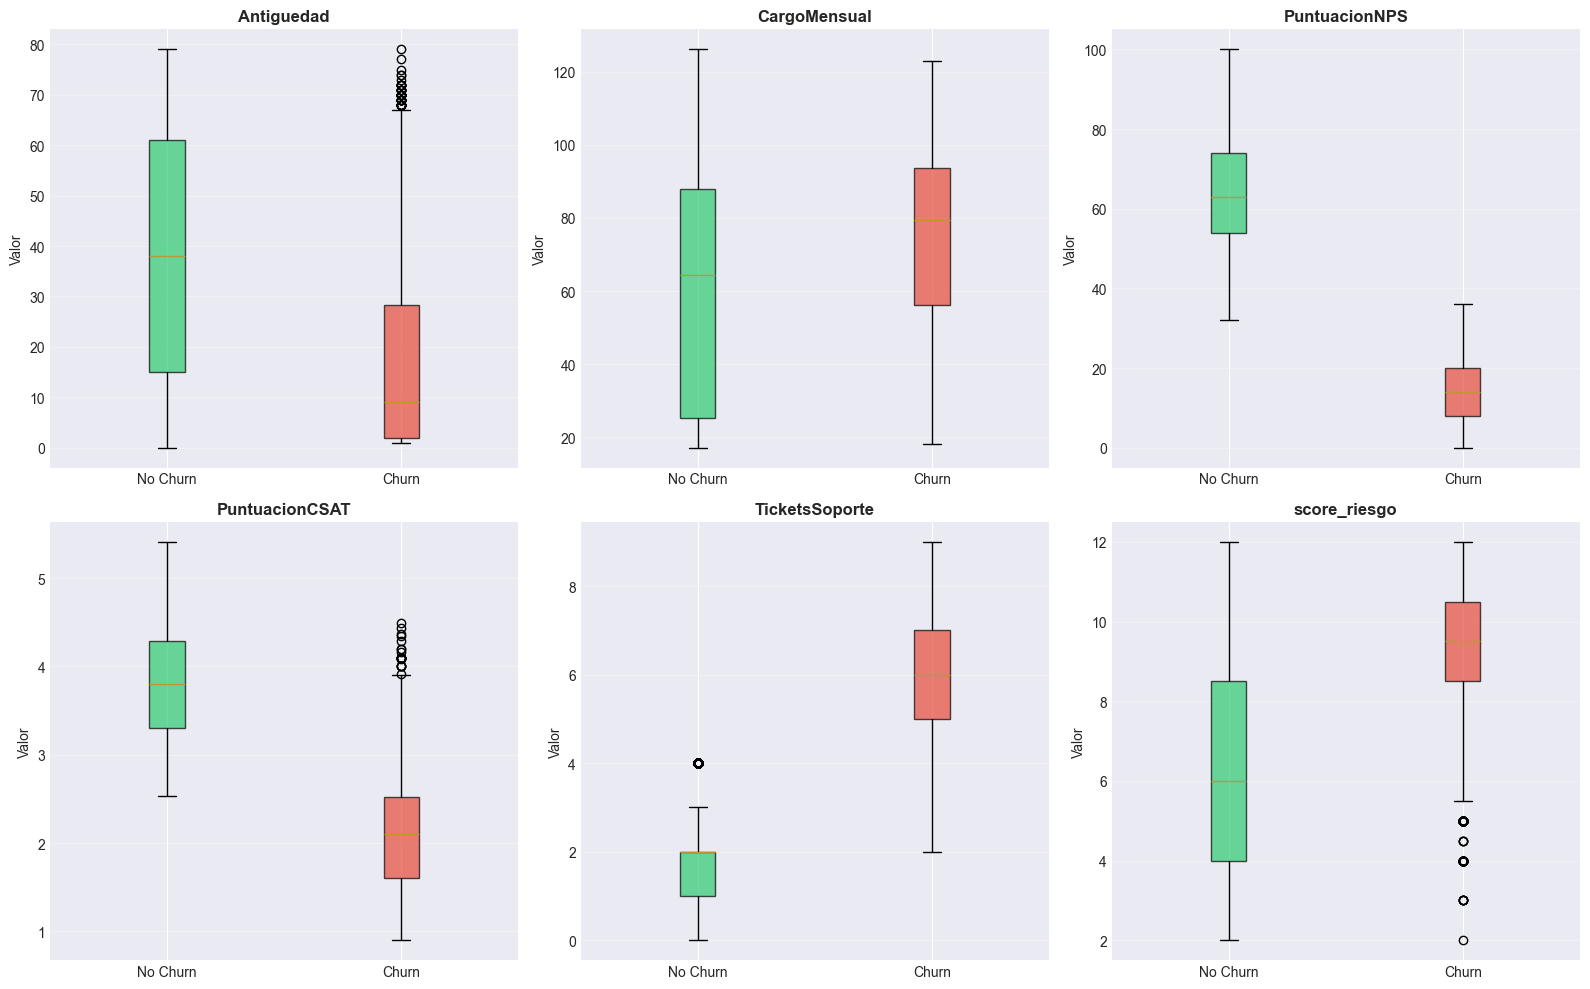

In [10]:
# Visualización comparación con boxplots
comparison_vars_plot = ['Antiguedad', 'CargoMensual', 'PuntuacionNPS',
                        'PuntuacionCSAT', 'TicketsSoporte', 'score_riesgo']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, var in enumerate(comparison_vars_plot):
    data_to_plot = [no_churners[var].dropna(), churners[var].dropna()]
    bp = axes[i].boxplot(data_to_plot, labels=['No Churn', 'Churn'], patch_artist=True)
    
    colors_box = ['#2ecc71', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[i].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Valor')
    axes[i].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/02_comparacion_churn.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Tasa de Churn por Categoría

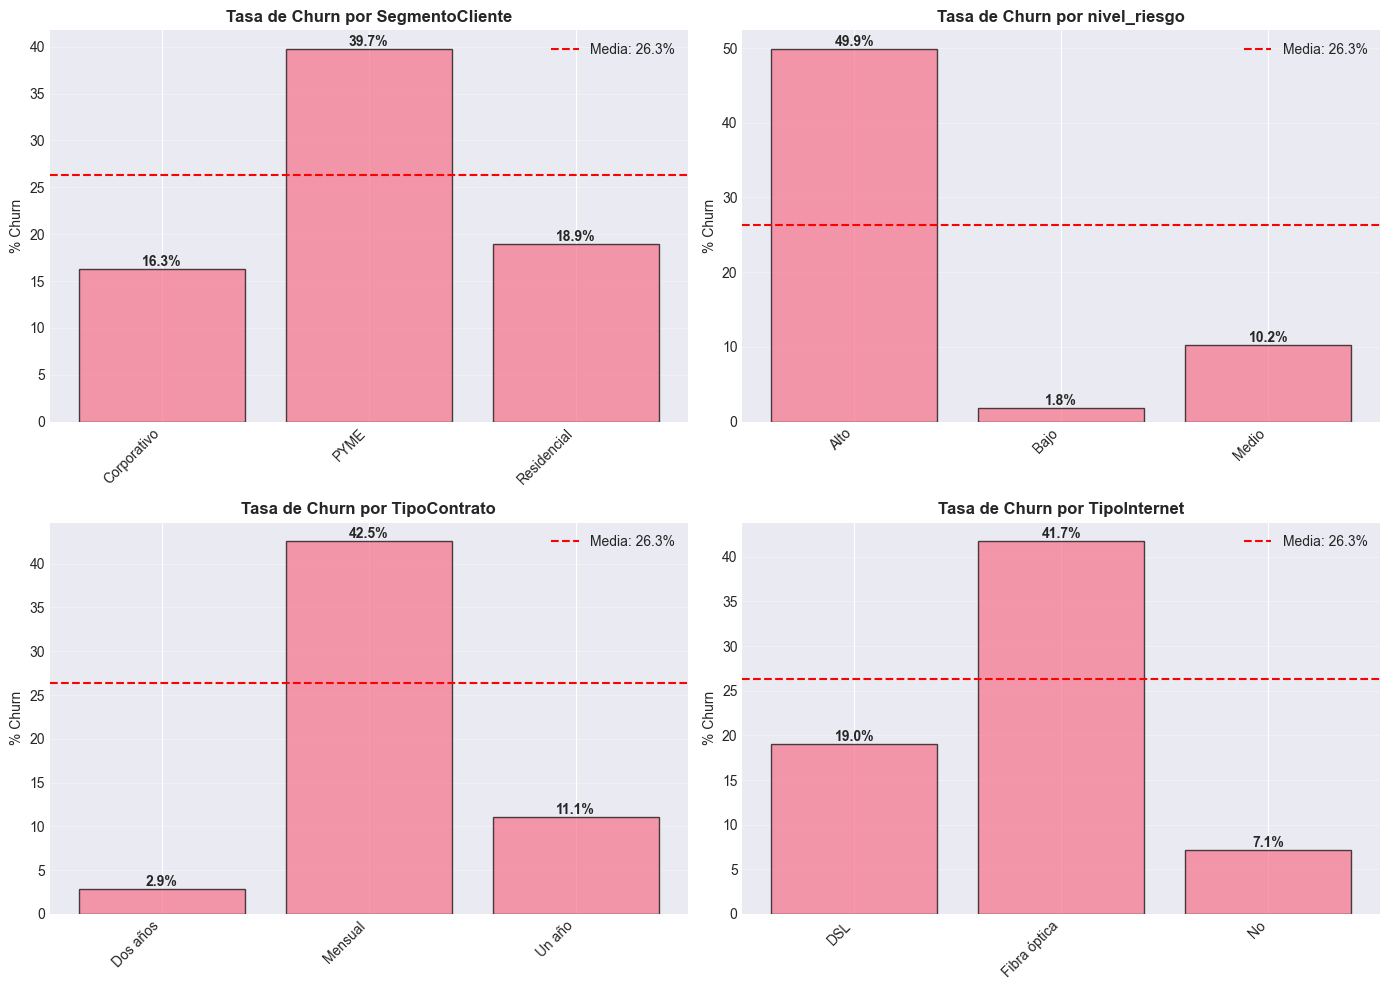

In [11]:
categorical_analysis = ['SegmentoCliente', 'nivel_riesgo', 'TipoContrato', 'TipoInternet']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, cat in enumerate(categorical_analysis):
    churn_by_cat = df.groupby(cat)['Cancelacion'].apply(lambda x: (x=='Si').sum() / len(x) * 100)
    
    axes[i].bar(range(len(churn_by_cat)), churn_by_cat.values, edgecolor='black', alpha=0.7)
    axes[i].set_xticks(range(len(churn_by_cat)))
    axes[i].set_xticklabels(churn_by_cat.index, rotation=45, ha='right')
    axes[i].set_title(f'Tasa de Churn por {cat}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('% Churn')
    axes[i].grid(alpha=0.3, axis='y')
    axes[i].axhline(y=churn_rate, color='red', linestyle='--', label=f'Media: {churn_rate:.1f}%')
    axes[i].legend()
    
    for j, v in enumerate(churn_by_cat.values):
        axes[i].text(j, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/02_churn_por_categoria.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Análisis de Correlaciones

Se seleccionaron 12 variables numéricas más relevantes:
- Excluidas: EsMayor (binaria), CodigoPostal (identificador), Latitud/Longitud (coordenadas), DensidadPoblacional (redundante), ratio_precio_ingreso (multicolinealidad), TasaClicsMarketing (correlacionada con TasaAperturaEmail)

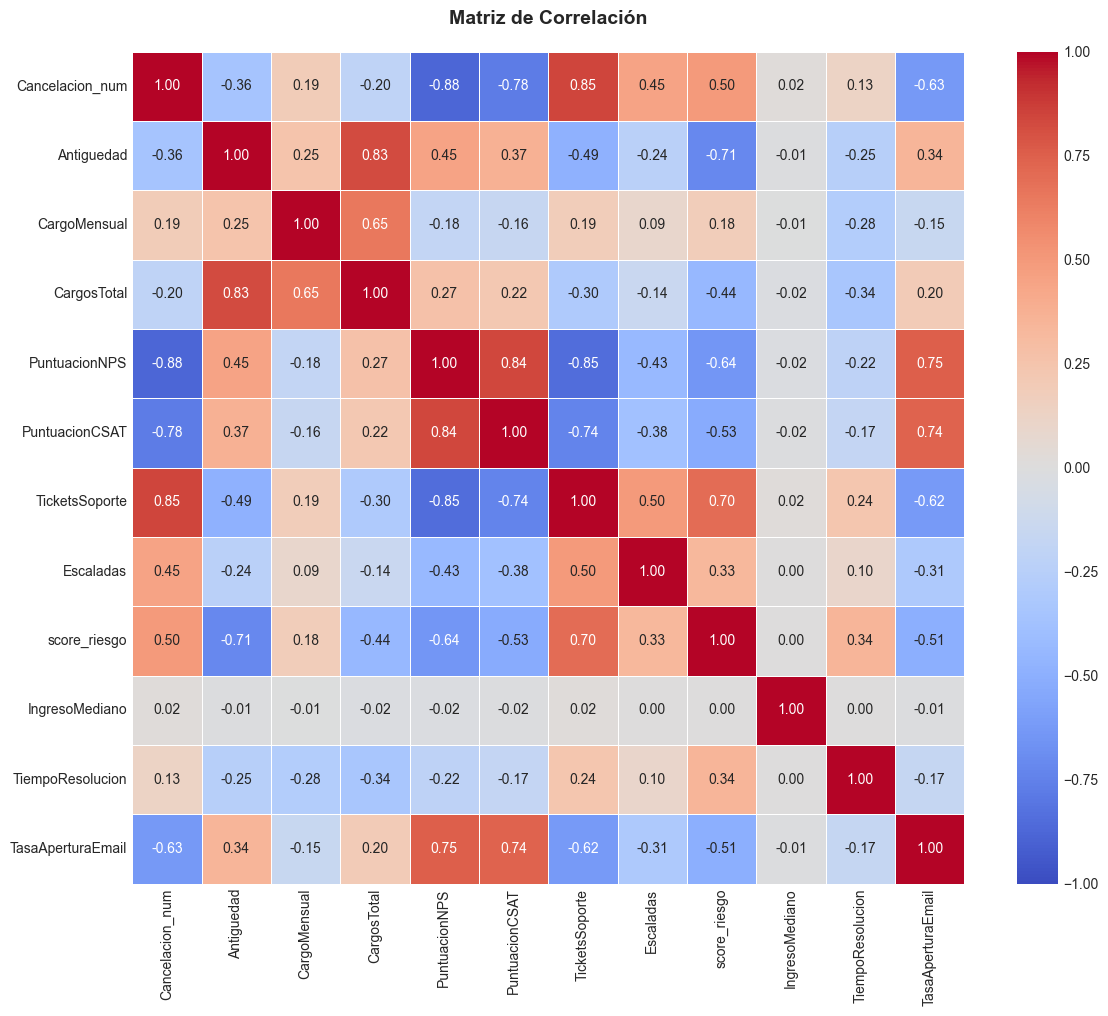

In [12]:
# Crear variable numérica del target
df_corr = df.copy()
df_corr['Cancelacion_num'] = (df_corr['Cancelacion'] == 'Si').astype(int)

# Variables seleccionadas para correlación
corr_vars = ['Cancelacion_num', 'Antiguedad', 'CargoMensual', 'CargosTotal', 'PuntuacionNPS',
             'PuntuacionCSAT', 'TicketsSoporte', 'Escaladas', 'score_riesgo',
             'IngresoMediano', 'TiempoResolucion', 'TasaAperturaEmail']

correlation_matrix = df_corr[corr_vars].corr()

# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Matriz de Correlación', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/02_matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Top correlaciones con Churn
churn_correlations = correlation_matrix['Cancelacion_num'].drop('Cancelacion_num').sort_values(ascending=False)

print("Top 10 Variables Correlacionadas con CHURN:\n")
for i, (var, corr) in enumerate(churn_correlations.head(10).items(), 1):
    print(f"{i:2d}. {var:<25} | {corr:>6.3f}")

Top 10 Variables Correlacionadas con CHURN:

 1. TicketsSoporte            |  0.847
 2. score_riesgo              |  0.495
 3. Escaladas                 |  0.447
 4. CargoMensual              |  0.191
 5. TiempoResolucion          |  0.133
 6. IngresoMediano            |  0.017
 7. CargosTotal               | -0.204
 8. Antiguedad                | -0.355
 9. TasaAperturaEmail         | -0.627
10. PuntuacionCSAT            | -0.779


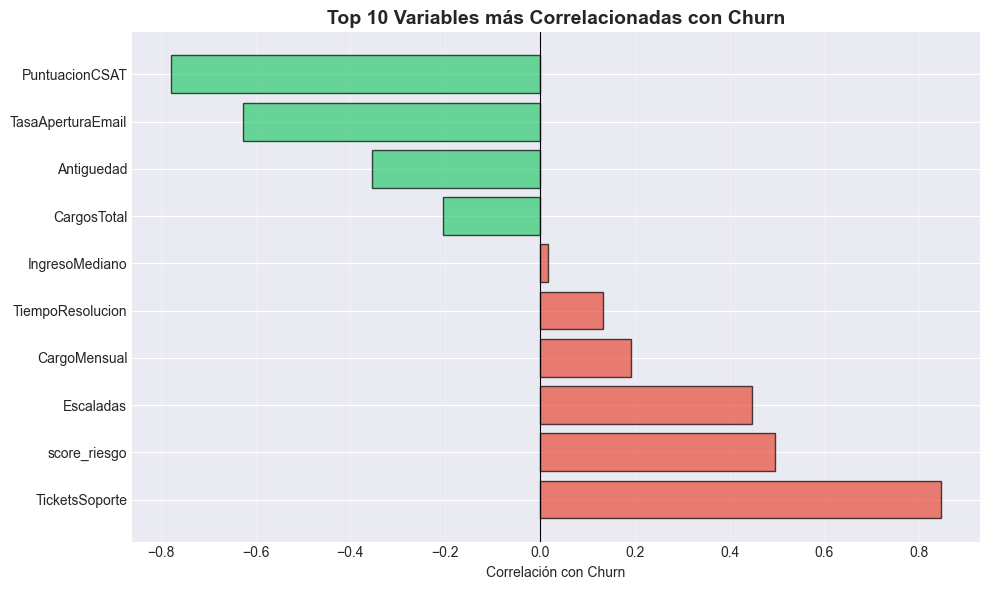

In [14]:
# Visualización top correlaciones
plt.figure(figsize=(10, 6))
top_corr = churn_correlations.head(10)
colors_corr = ['#e74c3c' if x > 0 else '#2ecc71' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors_corr, edgecolor='black', alpha=0.7)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlación con Churn')
plt.title('Top 10 Variables más Correlacionadas con Churn', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../reports/figures/02_top_correlaciones.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Análisis por Segmento

In [15]:
segment_analysis = df.groupby('SegmentoCliente').agg({
    'ClienteID': 'count',
    'Cancelacion': lambda x: (x=='Si').sum() / len(x) * 100,
    'CargoMensual': 'mean',
    'Antiguedad': 'mean',
    'PuntuacionNPS': 'mean',
    'TicketsSoporte': 'mean'
}).round(2)

segment_analysis.columns = ['Total_Clientes', 'Tasa_Churn_%', 'Cargo_Promedio',
                            'Antiguedad_Promedio', 'NPS_Promedio', 'Tickets_Promedio']

print(segment_analysis)

                 Total_Clientes  Tasa_Churn_%  Cargo_Promedio  \
SegmentoCliente                                                 
Corporativo                1808         16.32           98.96   
PYME                       3684         39.74           80.74   
Residencial                4209         18.94           35.78   

                 Antiguedad_Promedio  NPS_Promedio  Tickets_Promedio  
SegmentoCliente                                                       
Corporativo                    55.00         59.64              1.98  
PYME                           29.66         42.56              3.75  
Residencial                    25.09         53.95              2.62  


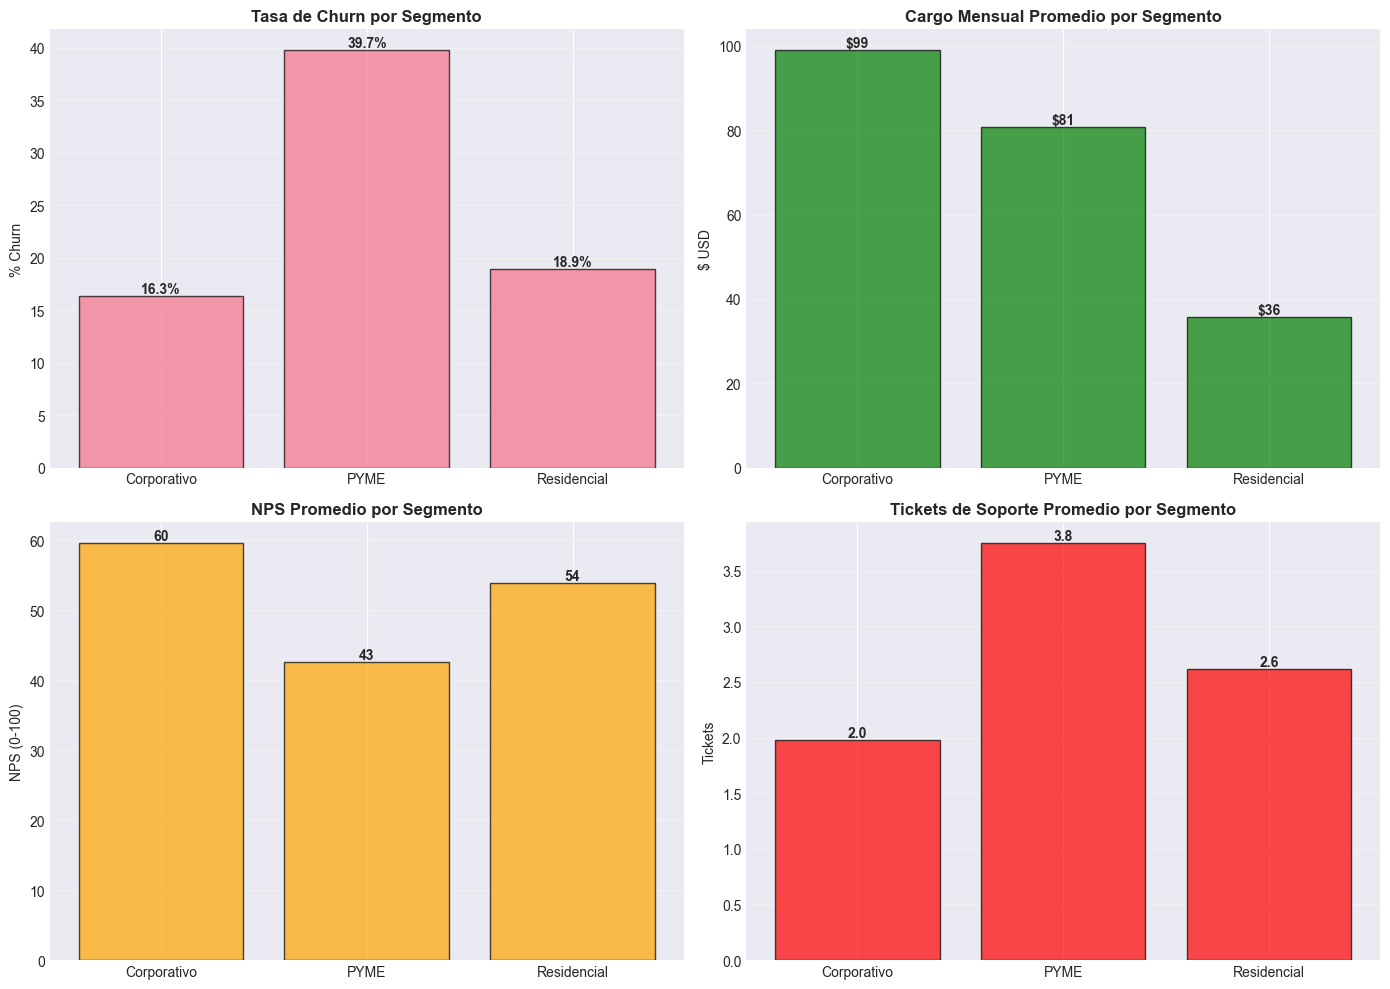

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Tasa de churn
axes[0].bar(segment_analysis.index, segment_analysis['Tasa_Churn_%'],
            edgecolor='black', alpha=0.7)
axes[0].set_title('Tasa de Churn por Segmento', fontweight='bold')
axes[0].set_ylabel('% Churn')
axes[0].grid(alpha=0.3, axis='y')
for i, v in enumerate(segment_analysis['Tasa_Churn_%']):
    axes[0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Cargo promedio
axes[1].bar(segment_analysis.index, segment_analysis['Cargo_Promedio'],
            edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Cargo Mensual Promedio por Segmento', fontweight='bold')
axes[1].set_ylabel('$ USD')
axes[1].grid(alpha=0.3, axis='y')
for i, v in enumerate(segment_analysis['Cargo_Promedio']):
    axes[1].text(i, v, f'${v:.0f}', ha='center', va='bottom', fontweight='bold')

# NPS promedio
axes[2].bar(segment_analysis.index, segment_analysis['NPS_Promedio'],
            edgecolor='black', alpha=0.7, color='orange')
axes[2].set_title('NPS Promedio por Segmento', fontweight='bold')
axes[2].set_ylabel('NPS (0-100)')
axes[2].grid(alpha=0.3, axis='y')
for i, v in enumerate(segment_analysis['NPS_Promedio']):
    axes[2].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# Tickets promedio
axes[3].bar(segment_analysis.index, segment_analysis['Tickets_Promedio'],
            edgecolor='black', alpha=0.7, color='red')
axes[3].set_title('Tickets de Soporte Promedio por Segmento', fontweight='bold')
axes[3].set_ylabel('Tickets')
axes[3].grid(alpha=0.3, axis='y')
for i, v in enumerate(segment_analysis['Tickets_Promedio']):
    axes[3].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/02_analisis_segmentos.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Análisis Geográfico

In [17]:
geo_analysis = df.groupby('Borough').agg({
    'ClienteID': 'count',
    'Cancelacion': lambda x: (x=='Si').sum() / len(x) * 100,
    'IngresoMediano': 'first',
    'CargoMensual': 'mean',
    'PuntuacionNPS': 'mean'
}).round(2)

geo_analysis.columns = ['Total_Clientes', 'Tasa_Churn_%', 'Ingreso_Mediano',
                        'Cargo_Promedio', 'NPS_Promedio']
geo_analysis = geo_analysis.sort_values('Tasa_Churn_%', ascending=False)

print(geo_analysis)

               Total_Clientes  Tasa_Churn_%  Ingreso_Mediano  Cargo_Promedio  \
Borough                                                                        
MANHATTAN                1985         29.02            85000           64.82   
STATEN ISLAND             504         26.59            82000           65.02   
BROOKLYN                 2838         26.39            63000           64.85   
BRONX                    1968         25.66            42000           65.15   
QUEENS                   2406         24.61            72000           63.70   

               NPS_Promedio  
Borough                      
MANHATTAN             48.94  
STATEN ISLAND         49.87  
BROOKLYN              51.25  
BRONX                 50.89  
QUEENS                51.46  


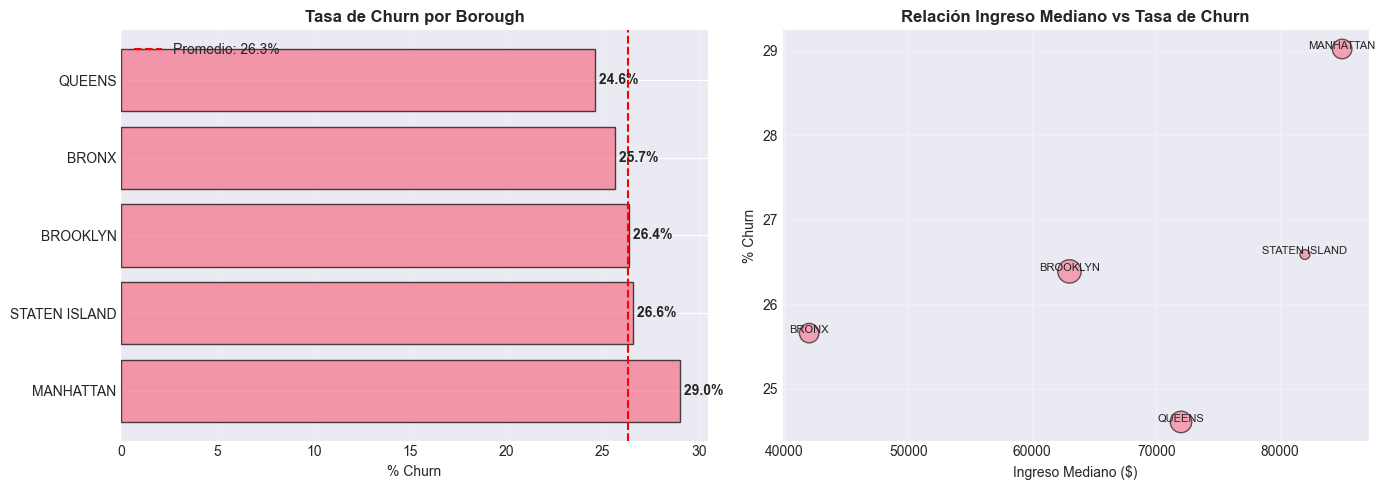

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(geo_analysis.index, geo_analysis['Tasa_Churn_%'],
             edgecolor='black', alpha=0.7)
axes[0].set_title('Tasa de Churn por Borough', fontsize=12, fontweight='bold')
axes[0].set_xlabel('% Churn')
axes[0].grid(alpha=0.3, axis='x')
axes[0].axvline(x=churn_rate, color='red', linestyle='--', label=f'Promedio: {churn_rate:.1f}%')
axes[0].legend()

for i, v in enumerate(geo_analysis['Tasa_Churn_%']):
    axes[0].text(v, i, f' {v:.1f}%', va='center', fontweight='bold')

axes[1].scatter(geo_analysis['Ingreso_Mediano'], geo_analysis['Tasa_Churn_%'],
                s=geo_analysis['Total_Clientes']/10, alpha=0.6, edgecolors='black')
axes[1].set_title('Relación Ingreso Mediano vs Tasa de Churn', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Ingreso Mediano ($)')
axes[1].set_ylabel('% Churn')
axes[1].grid(alpha=0.3)

for idx, row in geo_analysis.iterrows():
    axes[1].annotate(idx, (row['Ingreso_Mediano'], row['Tasa_Churn_%']),
                     fontsize=8, ha='center')

plt.tight_layout()
plt.savefig('../reports/figures/02_analisis_geografico.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Conclusiones y Próximos Pasos

### Hallazgos Clave:
- **Tasa de churn balanceada**: 26.35% (excelente para ML)
- **Predictor más fuerte**: TicketsSoporte (correlación +0.847)
- **Satisfacción crítica**: PuntuacionCSAT y PuntuacionNPS altamente correlacionados negativamente
- **Segmento vulnerable**: PYME tiene la mayor tasa de churn (~40%)
- **Contratos mensuales**: Alto riesgo vs contratos largos

### Recomendaciones para DS-503 (Feature Engineering):
1. Crear tenure_group (categorizar antigüedad)
2. Crear has_queja (flag binario)
3. Crear alto_tickets (flag binario >3)
4. Crear nps_categoria (Detractor/Pasivo/Promotor)
5. Crear servicios_premium_count
6. Imputar TipoDeQueja NULL con 'Sin Queja'
7. Normalizar variables numéricas
8. OneHotEncoding para categóricas

**Listo para DS-503 (Feature Engineering)**